In [1]:
import pandas as pd

### Handling initial data file

In [2]:
df = pd.read_excel("rawdata\online_retail_II.xlsx", parse_dates=["InvoiceDate"], sheet_name=[0,1])

In [3]:
df[0].shape

(525461, 8)

In [4]:
df[1].shape

(541910, 8)

In [5]:
#Merge sheets
df_retail_data = pd.concat([df[0], df[1]])

In [6]:
df_retail_data.shape

(1067371, 8)

In [7]:
df_retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
# Total of products
len(df_retail_data['StockCode'].unique())

5305

In [9]:
# List of countries
df_retail_data['Country'].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland', 'Saudi Arabia',
       'Czech Republic', 'European Community'], dtype=object)

In [10]:
# Total of countries
len(df_retail_data['Country'].unique())

43

In [11]:
# Total of clients
len(df_retail_data['Customer ID'].unique())

5943

In [12]:
#Checking null values
df_retail_data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [13]:
#Create calculated column: TotalAmount
df_retail_data['TotalAmount'] = df_retail_data['Quantity'] * df_retail_data['Price']

In [14]:
df_retail_data_indexed = df_retail_data[['InvoiceDate','TotalAmount']]
df_retail_data_indexed.index = df_retail_data_indexed['InvoiceDate']#pd.to_datetime(b['InvoiceDate'],format='%m/%d/%y %I:%M%p')

In [15]:
#Monthly data
df_grouped_monthly = df_retail_data_indexed.groupby(pd.Grouper(freq='M'))

In [16]:
#Columns count - by month
df_grouped_monthly.sum()

,TotalAmount
InvoiceDate,
2009-12-31,799847.110
2010-01-31,624032.892
2010-02-28,533091.426
2010-03-31,765848.761
2010-04-30,590580.432
2010-05-31,615322.830
2010-06-30,679786.610
2010-07-31,575236.360
2010-08-31,656776.340


In [17]:
#Daily data
df_grouped_daily = df_retail_data_indexed.groupby(pd.Grouper(freq='D'))

In [18]:
#Columns count - by day
df_grouped_daily.sum()

,TotalAmount
InvoiceDate,
2009-12-01,53173.03
2009-12-02,62763.59
2009-12-03,68093.05
2009-12-04,40346.40
2009-12-05,9803.05
...,...
2011-12-05,57751.32
2011-12-06,54228.37
2011-12-07,75076.22


In [19]:
#Hourly data
df_grouped_hourly = df_retail_data_indexed.groupby(pd.Grouper(freq='1h'))

In [20]:
#Columns count - by hour
df_grouped_hourly.sum()

,TotalAmount
InvoiceDate,
2009-12-01 07:00:00,651.10
2009-12-01 08:00:00,0.00
2009-12-01 09:00:00,5165.23
2009-12-01 10:00:00,4207.76
2009-12-01 11:00:00,6125.91
...,...
2011-12-09 08:00:00,3581.93
2011-12-09 09:00:00,3176.95
2011-12-09 10:00:00,19438.73


## Problem Definition

The group decided to go ahead with the following time series study: **"Predict daily billing amount"**

In [21]:
df_final_data = df_grouped_daily.sum()

## Create CSV file

In [22]:
df_final_data.head()

,TotalAmount
InvoiceDate,
2009-12-01,53173.03
2009-12-02,62763.59
2009-12-03,68093.05
2009-12-04,40346.40
2009-12-05,9803.05


In [23]:
df_final_data.shape

(739, 1)

In [24]:
#Create CSV with daily amounts removind the days without sales (should we?)
df_final_data[df_final_data['TotalAmount'] > 0].to_csv("./data/retail_daily_amount.csv")

## Read Time Series

In [25]:
import matplotlib.pyplot as plt

In [27]:
ts_data = pd.read_csv('./data/retail_daily_amount.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [28]:
ts_data.head()

InvoiceDate
2009-12-01    53173.03
2009-12-02    62763.59
2009-12-03    68093.05
2009-12-04    40346.40
2009-12-05     9803.05
Name: TotalAmount, dtype: float64

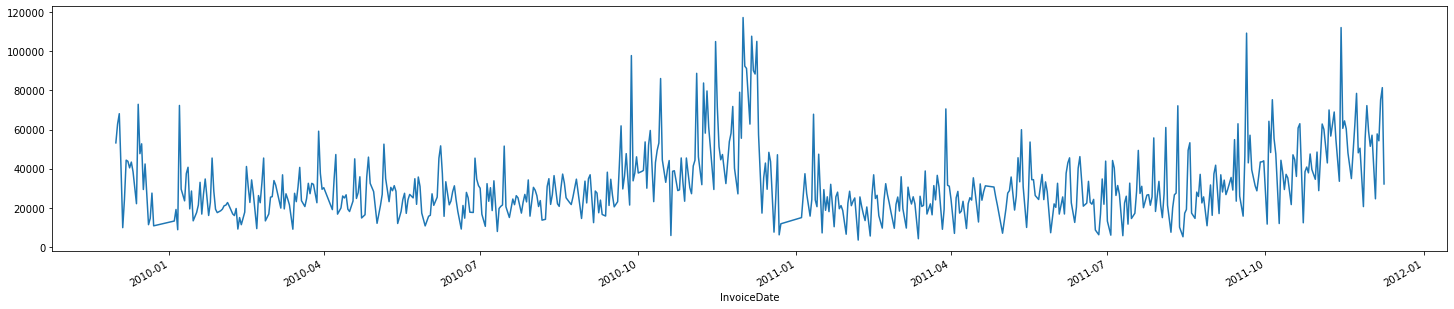

In [29]:
plt.figure(figsize=(25,5))
ts_data.dropna().plot()
plt.show()

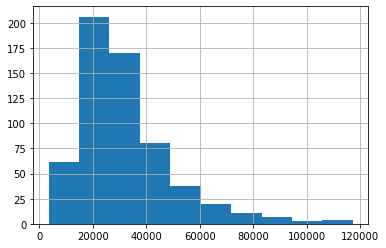

In [30]:
ts_data.hist()
plt.show()